# Piecewise Warping

This notebook shows how to fit a piecewise linear warping model and perform a hyperparameter search to tune the regularization strengths.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Generate a dataset from a piecewise warped model.

In [2]:
from affinewarp.datasets import piecewise_warped_data
binned, true_model = piecewise_warped_data()

#### Fit a model to make sure we approximate the ground truth.

In [3]:
# Fit warping model.
from affinewarp import PiecewiseWarping

est_model = PiecewiseWarping(n_knots=1, warp_reg_scale=1e-2, smoothness_reg_scale=20.0)
est_model.fit(binned, iterations=150, warp_iterations=100)

Loss improvement: 1.28%: 100%|██████████| 150/150 [00:12<00:00, 11.58it/s]


Text(0,0.5,'loss')

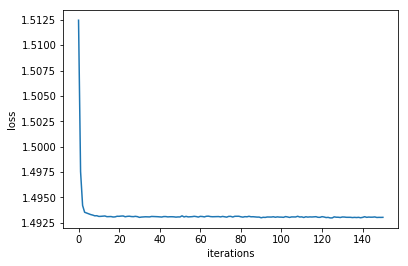

In [4]:
# Learning curve.
plt.plot(est_model.loss_hist)
plt.xlabel('iterations')
plt.ylabel('loss')

#### Compare estimated model to ground truth.

Text(0.5,1,'Estimated warping functions')

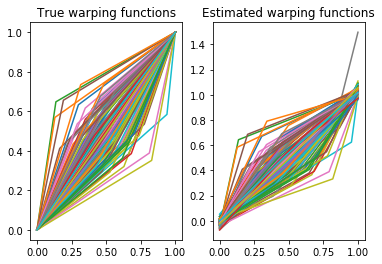

In [5]:
# Compare true warping functions to estimated model.
fig, axes = plt.subplots(1, 2)

axes[0].plot(true_model.x_knots.T, true_model.y_knots.T);
axes[0].set_title("True warping functions")

axes[1].plot(est_model.x_knots.T, est_model.y_knots.T);
axes[1].set_title("Estimated warping functions")

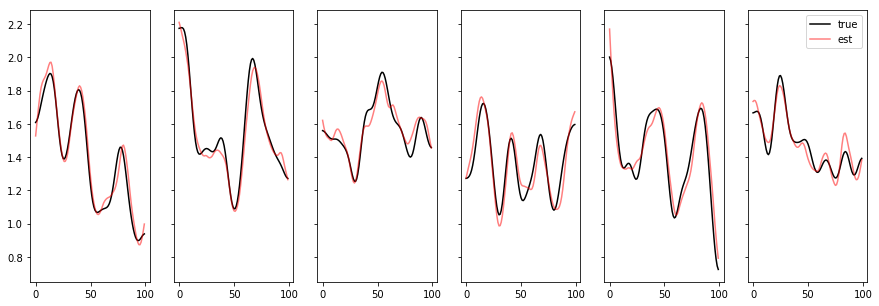

In [6]:
# Compare true template to estimated template across some neurons
fig, axes = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.plot(true_model.template[:, i], color='k', label='true')
    ax.plot(est_model.template[:, i], color='r', alpha=.5, label='est')

axes[-1].legend()    

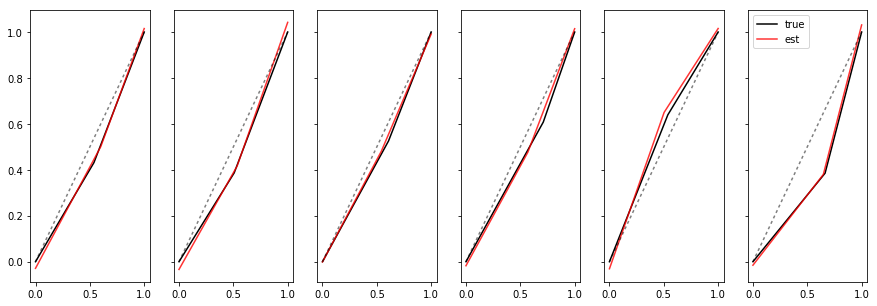

In [7]:
# Compare true warping functions to estimated warping functions.
fig, axes = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.plot(true_model.x_knots[i], true_model.y_knots[i], color='k', label='true')
    ax.plot(est_model.x_knots[i], est_model.y_knots[i], color='r', alpha=.8, label='est')
    ax.plot([0, 1], [0, 1], color='k', dashes=[2, 2], alpha=.5)

axes[-1].legend()    

## Perform a hyperparameter search

Above, we hand-tuned the model regularization to get a good fit. Here we take a more unbiased approach by randomly sampling different hyperparameters and comparing their performance on a held out set of units.

In [8]:
from affinewarp.crossval import paramsearch

search_params = {
    'n_models': 100,
    'smoothness_range': (1e-1, 1e3),
    'warpreg_range': (1e-3, 2.0)
}

scores, raw_scores, knots, smoothness, warp_reg = paramsearch(binned, **search_params)

100%|██████████| 100/100 [06:32<00:00,  3.92s/it]


#### Visualize the results of the hyperparameter search

We will plot models with different warping complexity as different colors (Blue = shift warping; Orange = linear warping; Green = piecewise linear warping with 1 discontinuity/knot). Then we plot regularization strength on the x-axis and the test error on the y-axis.

In [9]:
def get_label(knot_param):
    """Determines legend label."""
    if knot_param == -1:
        return 'shift'
    elif knot_param == 0:
        return 'linear'
    else:
        return str(k) + ' knot'

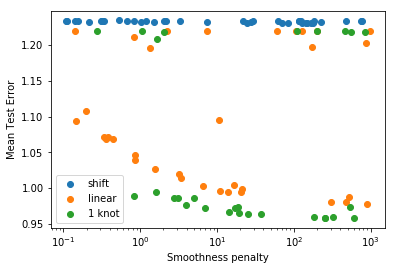

In [10]:
# Make plot of smoothness regularization strength vs test error.
plt.figure()

for k in np.unique(knots):
    idx = knots == k
    plt.plot(smoothness[idx], np.mean(scores[idx], axis=1), 'o', label=get_label(k))

plt.xscale('log')
plt.ylabel('Mean Test Error')
plt.xlabel('Smoothness penalty')
plt.legend()

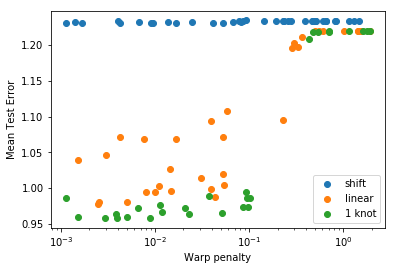

In [11]:
# Make plot of warp regularization strength vs test error.
plt.figure()

for k in np.unique(knots):
    idx = knots == k
    plt.plot(warp_reg[idx], np.mean(scores[idx], axis=1), 'o', label=get_label(k))

plt.xscale('log')
plt.ylabel('Mean Test Error')
plt.xlabel('Warp penalty')
plt.legend()

#### Conclusion

We see that low penalty on warping (distance from identity) and a moderately large roughness penalty work well for this synthetic dataset. Also, the piecewise warping model outperformed the linear and shift-only model.